In [1]:
%matplotlib inline
import math
from tqdm import tqdm
from typing import Iterable, List
from timeit import default_timer as timer
import numpy as np

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import datasets
from datasets import load_dataset
import evaluate
bleu_metric = evaluate.load("bleu")

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Предобработка данных

In [3]:
dataset = load_dataset("tatoeba", lang1="en", lang2="ru")

C:\jupyter\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for tatoeba contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tatoeba
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
TRAIN_SIZE = 30000
VAL_SIZE = 2000
train_ds = dataset['train'].select(range(TRAIN_SIZE))
val_ds = dataset['train'].select(range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE))

In [5]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'ru'
# Placeholders
token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='ru_core_news_sm')

In [6]:
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
#     language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
    for data_sample in data_iter:
        yield token_transform[language](data_sample['translation'][language])

In [7]:
# Define special symbols and indices
PAD_IDX, UNK_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = train_ds
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set `UNK_IDX` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [9]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [10]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.bool()


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [11]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, hug_dataset: datasets.arrow_dataset.Dataset, tokenizer, embedder, device=DEVICE):
        self.hug_dataset = hug_dataset # hugging dataset object
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.device = device

    def __getitem__(self, idx):
        item_dict = self.hug_dataset[idx]['translation']
        src = item_dict[SRC_LANGUAGE]
        tgt = item_dict[TGT_LANGUAGE]
        for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
            item_dict[ln] = item_dict[ln].rstrip("\n")
            item_dict[ln] = torch.cat((torch.tensor([SOS_IDX]), 
                       torch.tensor(self.embedder[ln](self.tokenizer[ln](item_dict[ln]))),
                       torch.tensor([EOS_IDX])))
        return item_dict[SRC_LANGUAGE], item_dict[TGT_LANGUAGE], tgt

    def __len__(self):
        return len(self.hug_dataset)

In [12]:
def collate_fn(batch):
    # pad_sequence is an in-built method proivded by torch package
    src_batch, tgt_batch, target = [], [], []
    for src_sample, tgt_sample, tgt in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)
        target.append(tgt)
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch, target

In [14]:
def train_epoch(model, optimizer, criterion, train_dataloader):
    model.train()
    losses = 0

    for src, tgt, real in tqdm(train_dataloader, total=len(list(train_dataloader))):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # Remove last entry an all target sequences (typically PAD, can be EOS)
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        # Remove <SOS> from all targets
        tgt_out = tgt[1:, :]
        
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    
    return losses / len(list(train_dataloader))


def evaluate(model, val_dataloader):
    model.eval()
    losses = 0
    all_answers = []
    all_labels = []

    for src, tgt, real in tqdm(val_dataloader, total=len(list(val_dataloader))):
        if(len(real)<200):
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            tgt_input = tgt[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

            tgt_out = tgt[1:, :]

            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            losses += loss.item()
        
    return losses / len(list(val_dataloader))

In [15]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

bleu, train_losses, val_losses = [],[],[]
train_dataset = MyDataset(train_ds, token_transform, vocab_transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
eval_dataset = MyDataset(val_ds, token_transform, vocab_transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Create model
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

# Initialize weights
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Move model to device (ideally GPU, otherwise CPU)
transformer = transformer.to(DEVICE)

# Define loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Define optimizer
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

C:\jupyter\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
NUM_EPOCHS = 30

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, criterion, train_dataloader)
    train_losses.append(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer, eval_dataloader)
    val_losses.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time (total) = {(end_time - start_time):.3f}s"))

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.10it/s]


Epoch: 1, Train loss: 6.382, Val loss: 5.175, Epoch time (total) = 40.679s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.12it/s]


Epoch: 2, Train loss: 5.286, Val loss: 4.843, Epoch time (total) = 40.837s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.85it/s]


Epoch: 3, Train loss: 4.845, Val loss: 4.486, Epoch time (total) = 41.501s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.80it/s]


Epoch: 4, Train loss: 4.473, Val loss: 4.175, Epoch time (total) = 42.376s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.13it/s]


Epoch: 5, Train loss: 4.145, Val loss: 3.892, Epoch time (total) = 44.200s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.00it/s]


Epoch: 6, Train loss: 3.853, Val loss: 3.653, Epoch time (total) = 44.581s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.72it/s]


Epoch: 7, Train loss: 3.580, Val loss: 3.445, Epoch time (total) = 45.312s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.08it/s]


Epoch: 8, Train loss: 3.328, Val loss: 3.292, Epoch time (total) = 44.675s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.26it/s]


Epoch: 9, Train loss: 3.107, Val loss: 3.183, Epoch time (total) = 44.651s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.73it/s]


Epoch: 10, Train loss: 2.904, Val loss: 3.049, Epoch time (total) = 45.808s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.37it/s]


Epoch: 11, Train loss: 2.704, Val loss: 2.963, Epoch time (total) = 45.957s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.47it/s]


Epoch: 12, Train loss: 2.528, Val loss: 2.874, Epoch time (total) = 45.224s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.80it/s]


Epoch: 13, Train loss: 2.362, Val loss: 2.812, Epoch time (total) = 44.644s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.74it/s]


Epoch: 14, Train loss: 2.209, Val loss: 2.801, Epoch time (total) = 44.745s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.03it/s]


Epoch: 15, Train loss: 2.072, Val loss: 2.798, Epoch time (total) = 45.207s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.09it/s]


Epoch: 16, Train loss: 1.935, Val loss: 2.726, Epoch time (total) = 45.693s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.01it/s]


Epoch: 17, Train loss: 1.812, Val loss: 2.673, Epoch time (total) = 45.921s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.38it/s]


Epoch: 18, Train loss: 1.707, Val loss: 2.654, Epoch time (total) = 45.929s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.02it/s]


Epoch: 19, Train loss: 1.598, Val loss: 2.634, Epoch time (total) = 47.894s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.61it/s]


Epoch: 20, Train loss: 1.505, Val loss: 2.604, Epoch time (total) = 47.023s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.36it/s]


Epoch: 21, Train loss: 1.404, Val loss: 2.597, Epoch time (total) = 46.024s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.82it/s]


Epoch: 22, Train loss: 1.312, Val loss: 2.574, Epoch time (total) = 45.620s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.27it/s]


Epoch: 23, Train loss: 1.225, Val loss: 2.578, Epoch time (total) = 44.875s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.68it/s]


Epoch: 24, Train loss: 1.146, Val loss: 2.607, Epoch time (total) = 45.035s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.06it/s]


Epoch: 25, Train loss: 1.072, Val loss: 2.603, Epoch time (total) = 45.600s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.68it/s]


Epoch: 26, Train loss: 1.003, Val loss: 2.587, Epoch time (total) = 45.564s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.85it/s]


Epoch: 27, Train loss: 0.937, Val loss: 2.580, Epoch time (total) = 44.739s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.59it/s]


Epoch: 28, Train loss: 0.875, Val loss: 2.565, Epoch time (total) = 45.156s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.46it/s]


Epoch: 29, Train loss: 0.819, Val loss: 2.561, Epoch time (total) = 50.347s


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 29.89it/s]


Epoch: 30, Train loss: 0.762, Val loss: 2.565, Epoch time (total) = 46.018s


In [21]:
torch.save(transformer, 'models/transformerenu.pt')

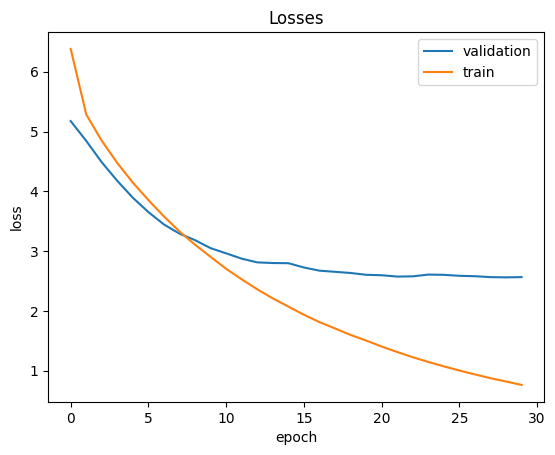

In [18]:
import matplotlib.pyplot as plt
plt.plot(val_losses, "-")
plt.plot(train_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["validation", "train"])
plt.title("Losses");

In [70]:
transformer = torch.load('models/transformerenu.pt')

In [25]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

# Actual method to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = src_sentence.rstrip("\n")
    src = torch.cat((torch.tensor([SOS_IDX]), 
                       torch.tensor(vocab_transform[SRC_LANGUAGE](token_transform[SRC_LANGUAGE](src))),
                       torch.tensor([EOS_IDX])))
    src = src.view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model, src, src_mask, max_len=num_tokens+5, start_symbol=SOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<SOS>", "").replace("<EOS>", "")

In [66]:
predictions, references=[],[]
for i in tqdm(val_ds):
    tgt = i['translation']['ru']
    src = i['translation']['en']
    if len(src)<200:
        references.append(tgt)
        predictions.append(translate(transformer, src))

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:53<00:00, 37.67it/s]


In [68]:
predictions[0]

' Тот человек в любви с моим сестрой . '

In [69]:
references[0]

'Этот человек влюблен в мою сестру.'

In [67]:
bleu_metric.compute(predictions=predictions, references=references)

{'bleu': 0.19910534644455488,
 'precisions': [0.534301188506093,
  0.25535682663361076,
  0.14191951796858188,
  0.08116259939676447],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0374590291868269,
 'translation_length': 13294,
 'reference_length': 12814}

In [71]:
translate(transformer, "I won't ask you anything else today.")

' Я больше не спрошу тебя об этом . '

In [34]:
translate(transformer, "For once in my life I'm doing a good deed... And it is useless.")

' В жизни я делаю хорошее дело ... Я ... И оно бесполезно . '

In [37]:
translate(transformer, "Good morning, how are you?")

' Доброе утро , как ты ? '